In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torchvision

In [3]:
input_path='C:/Users/AS-GP/Desktop/Resnet50/lisat_gaze_data_v1/'

In [4]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(), #for parallel computations
        normalize
    ]),
}

#train_subset_size = int(0.4 * len(datasets.ImageFolder(input_path + 'train_1250', transform=data_transforms['train']))) #testing hashelha b3den

image_datasets = {
    'train':
    datasets.ImageFolder(input_path + 'new/train', data_transforms['train']),
    'validation':
    datasets.ImageFolder(input_path + 'new/val', data_transforms['validation'])
}

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=32,
                                shuffle=True,
                                num_workers=2),  # for now 2
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=32,
                                shuffle=False,
                                num_workers=2)  # for Kaggle
}


In [5]:
print("Train dataset size:", len(image_datasets['train']))
print("Validation dataset size:", len(image_datasets['validation']))

Train dataset size: 24001
Validation dataset size: 6004


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [7]:
model =torchvision.models.squeezenet1_0(pretrained=True).to(device)
model

C:\Users\AS-GP\AppData\Local\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\AS-GP\AppData\Local\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to C:\Users\AS-GP/.cache\torch\hub\checkpoints\squeezenet1_0-b66bff10.pth
100%|██████████████████████████████████████████████████████████████████████████████| 4.78M/4.78M [00:06<00:00, 790kB/s]


SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [9]:
model =torchvision.models.squeezenet1_0(pretrained=True).to(device)

for param in model.parameters():
    param.requires_grad = False

# Define the custom classifier
classifier = nn.Sequential(
    nn.Dropout(p=0.5, inplace=False),
    nn.Conv2d(512, 8, kernel_size=(1, 1), stride=(1, 1)),
    nn.ReLU(inplace=True),
    nn.AdaptiveAvgPool2d(output_size=(1, 1)),
    #nn.Softmax(dim=1)
).to(device)

# Replace the default classifier with the custom one
model.classifier = classifier

model

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [10]:
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.classifier.parameters(),lr=0.0001,weight_decay = 0.01)
optimizer = optim.Adam(model.classifier.parameters(), 
                       lr=3e-4)

In [16]:
weights_path='squeezeNet.pt'

In [17]:
class EarlyStopper:
    def __init__(self, patience=10, min_delta=0.01):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_accuracy = 0

    def early_stop(self, current_accuracy):
        if (current_accuracy > self.best_accuracy + self.min_delta):
            self.best_accuracy = current_accuracy
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [18]:
early_stopper = EarlyStopper(15,0.01)
def train_model(model, criterion, optimizer, num_epochs=5):
    training_accuracies = []
    validation_accuracies = []
    training_accuracies.append(0)
    validation_accuracies.append(0)
    #optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate, weight_decay=weight_decay)
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train().to(device) #added to device
            else:
                model.eval().to(device)

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs).to(device)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                epoch_loss = running_loss / len(image_datasets[phase])
                epoch_acc = running_corrects.double() / len(image_datasets[phase])
                training_accuracies.append(epoch_acc.item()*100)
            else:
                epoch_loss = running_loss / len(image_datasets[phase])
                epoch_acc = running_corrects.double() / len(image_datasets[phase])
                validation_accuracies.append(epoch_acc.item()*100)
                if early_stopper.early_stop(epoch_acc.item()*100):
                    print('triggered ES Tacc: {:.4f}, Vacc: {:.4f}'.format(training_accuracies[-1], 
                                                                           validation_accuracies[-1]))            
                    return model,training_accuracies,validation_accuracies
            
                if epoch_acc.item()*100 >= early_stopper.best_accuracy:
                    #early_stopper.early_stop(epoch_acc.item()*100)
                    #early_stopper.best_accuracy = epoch_acc.item()*100
                    print('best accuracy {:.4f}'.format(early_stopper.best_accuracy))
                    torch.save(model.state_dict(), weights_path)
                    print(f"Model saved as it achieved the best validation accuracy so far {early_stopper.best_accuracy}" )

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
    return model,training_accuracies,validation_accuracies 

In [19]:
model_trained = train_model(model, criterion, optimizer, num_epochs=500) #1 epoch for testing gpu

Epoch 1/500
----------
train loss: 1.1606, acc: 0.6021
best accuracy 73.9174
Model saved as it achieved the best validation accuracy so far 73.91738840772818
validation loss: 0.7641, acc: 0.7392
Epoch 2/500
----------
train loss: 0.7243, acc: 0.7669
best accuracy 81.3125
Model saved as it achieved the best validation accuracy so far 81.31245836109261
validation loss: 0.5843, acc: 0.8131
Epoch 3/500
----------
train loss: 0.6115, acc: 0.8060
best accuracy 84.0107
Model saved as it achieved the best validation accuracy so far 84.01065956029315
validation loss: 0.5003, acc: 0.8401
Epoch 4/500
----------
train loss: 0.5548, acc: 0.8219
best accuracy 85.1432
Model saved as it achieved the best validation accuracy so far 85.14323784143905
validation loss: 0.4686, acc: 0.8514
Epoch 5/500
----------
train loss: 0.5258, acc: 0.8298
best accuracy 86.4424
Model saved as it achieved the best validation accuracy so far 86.44237175216523
validation loss: 0.4279, acc: 0.8644
Epoch 6/500
----------
tr

In [20]:
classes_labels = ['Eyes Closed','Forward','Left Mirror','Radio','Rearview','Right Mirror','Shoulder','Speedometer']

In [21]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(model, dataloader, num_classes):
    # Set the model to evaluation mode
    model.eval()

    # Initialize lists to store the true and predicted labels
    true_labels = []
    pred_labels = []

    # Iterate over the validation dataset
    with torch.no_grad():
        for images, labels in dataloader:

            # Move the input tensor to the same device as the model weights
            if next(model.parameters()).is_cuda:
                images = images.cuda()

            # Forward pass
            outputs = model(images)

            # Get the predicted labels
            _, predicted = torch.max(outputs.data, 1)


            # Store the true and predicted labels
            true_labels += labels.cpu().numpy().tolist()
            pred_labels += predicted.cpu().numpy().tolist()

    print(true_labels)
    # Compute the confusion matrix
    cm = confusion_matrix(true_labels, pred_labels)
    
    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.imshow(cm, cmap='Blues')
    plt.xticks(range(num_classes),classes_labels)
    plt.yticks(range(num_classes),classes_labels)
    cm = np.around(cm.astype('float')/cm.sum(axis=1)[:,np.newaxis],decimals=2)
    plt.colorbar()
    plt.clim(0, max(cm.max(), cm.sum()))
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      color = "white" if cm[i, j] > thresh else "black"
      plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)


    plt.tight_layout()
    plt.ylim(num_classes, -0.5)
    plt.show()
    

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

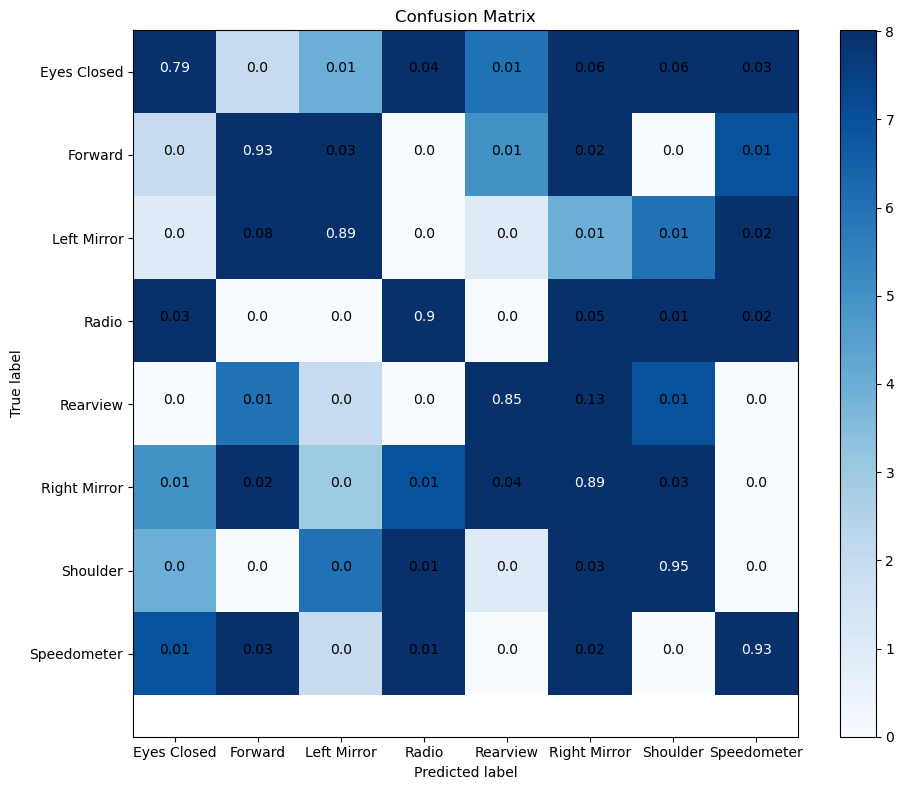

In [22]:
plot_confusion_matrix(model,dataloaders['validation'],8)

In [29]:
model_path='squeezeNet.pt'

model =torchvision.models.squeezenet1_0(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

# Define the custom classifier
classifier = nn.Sequential(
    nn.Dropout(p=0.5, inplace=False),
    nn.Conv2d(512, 8, kernel_size=(1, 1), stride=(1, 1)),
    nn.ReLU(inplace=True),
    nn.AdaptiveAvgPool2d(output_size=(1, 1)),
    #nn.Softmax(dim=1)
)

# Replace the default classifier with the custom one
model.classifier = classifier

model.load_state_dict(torch.load(model_path))

model.eval()
eyeGazeClasses = ['Eyes Closed', 'Forward', 'Left Mirror', 'Radio', 
                  'Rearview', 'Right Mirror', 'Shoulder', 'Speedometer']

In [88]:
import cv2
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    #transforms.RandomCrop((50, image_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# Preprocess the image (assuming frame is a path or numpy array)
frame = "test/cropped_with_box_40.png"
pil_image = Image.fromarray(cv2.cvtColor(cv2.imread(frame), cv2.COLOR_BGR2RGB))
width, height = pil_image.size
cropped_image = pil_image.crop((0, 0, width, 120))
input_image = transform(cropped_image).unsqueeze(0)  # Add batch dimension

# Make prediction
output = model(input_image)

# Get the predicted class with the highest probability
_, predicted = torch.max(output.data, 1)

# Print the predicted class
print(f"Predicted Class: {eyeGazeClasses[predicted.item()]}")
print(output)

Predicted Class: Forward
tensor([[10.9158, 19.8185, 19.5602,  6.7468, 17.0642, 17.0275, 16.9888, 10.9576]],
       grad_fn=<ViewBackward0>)


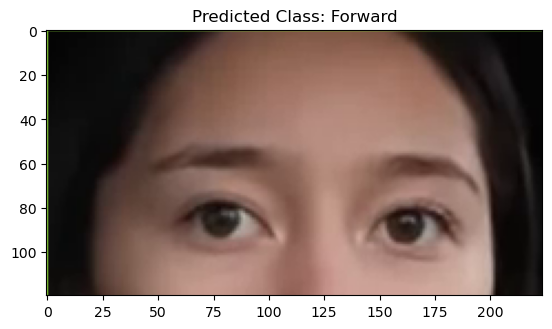

In [89]:
# Show the image (assuming it's a color image)
plt.imshow(cropped_image)
plt.title(f"Predicted Class: {eyeGazeClasses[predicted.item()]}")
plt.show()